# Analyse FerPlus



In [1]:
import os
import pandas as pd
import bz2
import _pickle as cPickle
import random
import numpy as np

import ferPlus_functions as dp
os.chdir(os.getcwd() + '/../')
import general_defenitions as gd

Set begin of all paths.

In [2]:
os.chdir(os.getcwd() + '/datasets/')

Read the two csv data files from the FerPlus dataset.

In [3]:
data = pd.read_csv('fer2013.csv')
labels = pd.read_csv('fer2013new.csv')

## 1. Data understanding

### 1.1 data exploration & analysis

Before we can start with the dataset, we need to know what it consists of. For this we will use analyzes and visualisations. This way we can gain a better understanding of our dataset.

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


Show cells that contain NULL values.

In [6]:
print('data:\n', pd.isnull(data).sum(), '\n\n')
print('labels:\n', pd.isnull(labels).sum())

data:
 emotion    0
pixels     0
Usage      0
dtype: int64 


labels:
 Usage           0
Image name    173
neutral         0
happiness       0
surprise        0
sadness         0
anger           0
disgust         0
fear            0
contempt        0
unknown         0
NF              0
dtype: int64


## 2. Data preparation

The following function will make sure an numpy array will be filles with arrays of pixels.

In [7]:
x, y = dp.preprocess_data(data, labels)

clean_data_and_normalize makes sure unneccesary columns will be removed. It also normalizes data and creates the target value by picking the highest chosen emotion for each image.

In [8]:
x, y = dp.clean_data_and_normalize(x, y)

Read the extra data coming from AffectNet dataset.

In [9]:
comp_data = bz2.BZ2File('../processed_sets/fear_disgust_affect', 'rb')
extra_x_train, extra_y_train = cPickle.load(comp_data)

Process AffectNet data to be the same as the FerPlus data.

In [10]:
x, y = dp.process_affectnet_data(x, y, extra_x_train, extra_y_train)

Make random list from all indexes

In [11]:
randomlist = random.sample(range(0, len(x)), len(x))

In [12]:
new_x = np.zeros((len(x), 48, 48, 1))
new_y = np.zeros((len(y), 7))

In [13]:
for index, rand_index in enumerate(randomlist):
    new_x[index] = x[rand_index]
    new_y[index] = y[rand_index]
    
x = new_x
y = new_y

The split data function will split the data into a train, test and validation set. The test set size wil be 10% of the entire dataset.

In [14]:
x_train, y_train, x_val, y_val, x_test, y_test = gd.split_data(x, y)

Remove all excess rows with an emotion to better balance our data.

In [15]:
x_train, y_train = dp.balance_emotions(x_train, y_train, 'neutral', 3000)
x_train, y_train = dp.balance_emotions(x_train, y_train, 'happiness', 3000)

This function will show 25 processed images.

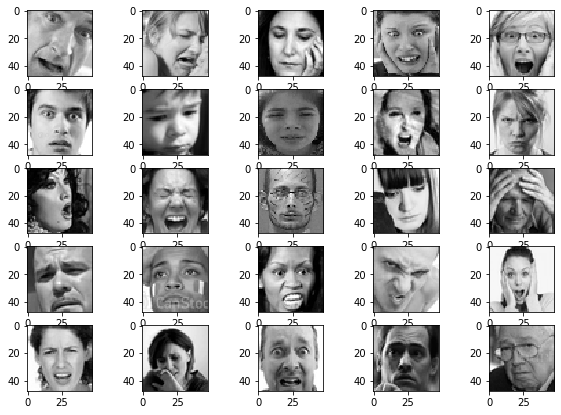

array([10.,  7.])

In [18]:
gd.show_images(x_train, y_train)

Now that we processed the data we can save it as a compressed pickle file using bz2.

In [19]:
filename = '../processed_sets/ferPlus_processed_combine'
data = [ x_train, y_train, x_val, y_val, x_test, y_test]

gd.comp_pickle_save(data, filename)

## Data augmentation
By augmenting the data we want to achieve a higher accuracy on our model.

Data augmentation will rotate all images by 20 degrees and shift it by a fraction of the whole image. The function data_augmentation will also mirror the image.

In [20]:
datagen = gd.data_augmentation(x_train)

The last function is going to show 25 of the images after augmenting.

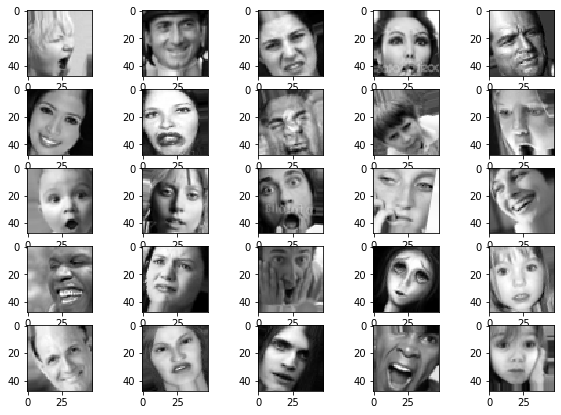

array([10.,  7.])

In [21]:
gd.show_images(x_train, y_train, datagen)

Dump all processed data into a compressed piickle file, this makes the size of the data as low as possible.

In [22]:
filename = '../processed_sets/ferPlus_augment_combine'
data = [ datagen, x_train, y_train, x_val, y_val, x_test, y_test]

gd.comp_pickle_save(data, filename)